In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms.functional as F

import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.insert(0, root_path)
import spectral
from spectral import dct2_2d, LinearDCT, DCTSpectralPooling

Benchmarking on: cuda
Size (N)   | FFT (ms)   | Linear (ms) | Speedup   
--------------------------------------------------
16         | 0.2159     | 0.0462     | 4.67      x
32         | 0.2137     | 0.0197     | 10.84     x
64         | 0.2295     | 0.0142     | 16.14     x
128        | 0.1923     | 0.0139     | 13.80     x
256        | 0.1908     | 0.0174     | 10.94     x
512        | 0.1969     | 0.0467     | 4.21      x
1024       | 0.4147     | 0.2418     | 1.72      x
2048       | 1.3813     | 2.1099     | 0.65      x
4096       | 5.2821     | 17.2737    | 0.31      x
8192       | 24.1404    | 145.5363   | 0.17      x


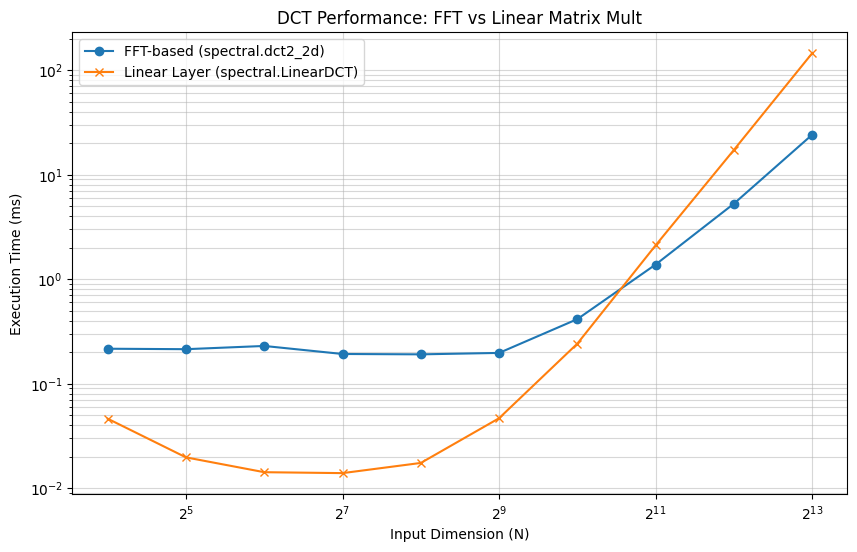

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Benchmarking on: {device}")
sizes = [2**i for i in range(4, 14)] 
num_repeats = 100
times_fft = []
times_linear = []

print(f"{'Size (N)':<10} | {'FFT (ms)':<10} | {'Linear (ms)':<10} | {'Speedup':<10}")
print("-" * 50)

for N in sizes:
    x = torch.randn(N, N, device=device)
    for _ in range(10): 
        _ = dct2_2d(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start = time.time()
    for _ in range(num_repeats):
        _ = dct2_2d(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    avg_fft = (time.time() - start) / num_repeats * 1000
    linear_layer = LinearDCT(N, type='dct').to(device)
    for _ in range(10):
        _ = linear_layer(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start = time.time()
    for _ in range(num_repeats):
        _ = linear_layer(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    avg_linear = (time.time() - start) / num_repeats * 1000
    times_fft.append(avg_fft)
    times_linear.append(avg_linear)
    speedup = avg_fft / avg_linear
    print(f"{N:<10} | {avg_fft:<10.4f} | {avg_linear:<10.4f} | {speedup:<10.2f}x")

plt.figure(figsize=(10, 6))
plt.plot(sizes, times_fft, label='FFT-based (spectral.dct2_2d)', marker='o')
plt.plot(sizes, times_linear, label='Linear Layer (spectral.LinearDCT)', marker='x')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('Input Dimension (N)')
plt.ylabel('Execution Time (ms)')
plt.title('DCT Performance: FFT vs Linear Matrix Mult')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()

Size (N)   | FFT (MB)   | Linear (MB)
----------------------------------------
32         | 0.03       | 0.00      
64         | 0.11       | 0.03      
128        | 0.44       | 0.12      
256        | 1.75       | 0.50      
512        | 7.01       | 2.00      
1024       | 28.01      | 8.00      
2048       | 112.02     | 32.00     
4096       | 448.05     | 128.00    
8192       | 1792.09    | 512.00    


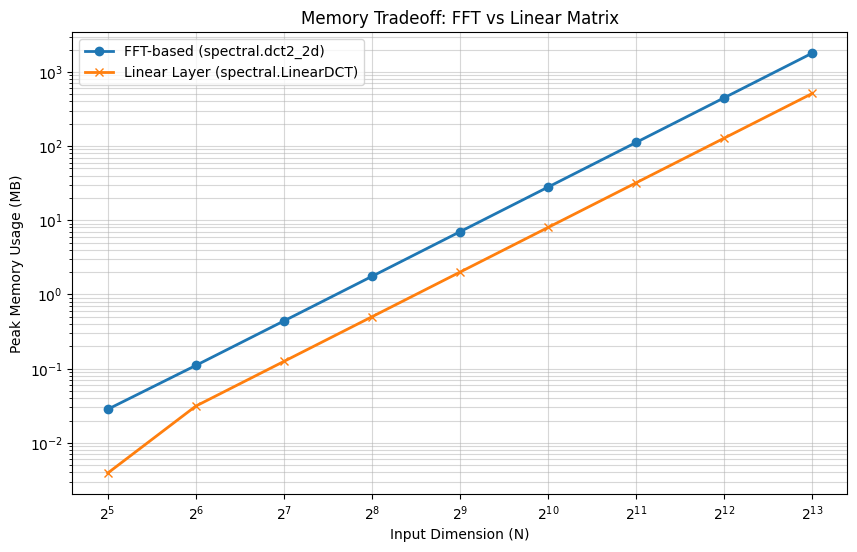

In [10]:
if not torch.cuda.is_available():
    print("This script requires a GPU to strictly measure VRAM usage.")
    exit()
device = torch.device('cuda')
sizes = [2**i for i in range(5, 14)]
mem_fft = []
mem_linear = []
print(f"{'Size (N)':<10} | {'FFT (MB)':<10} | {'Linear (MB)':<10}")
print("-" * 40)
for N in sizes:
    x = torch.randn(N, N, device=device)
    torch.cuda.reset_peak_memory_stats(device)
    baseline_mem = torch.cuda.memory_allocated(device)
    y = dct2_2d(x)
    peak_mem = torch.cuda.max_memory_allocated(device)
    mem_usage_mb = (peak_mem - baseline_mem) / 1024**2
    mem_fft.append(mem_usage_mb)
    del y
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)
    baseline_mem = torch.cuda.memory_allocated(device)
    linear_layer = LinearDCT(N, type='dct').to(device)
    y = linear_layer(x)
    peak_mem = torch.cuda.max_memory_allocated(device)
    mem_usage_mb = (peak_mem - baseline_mem) / 1024**2
    mem_linear.append(mem_usage_mb)
    del linear_layer, y
    torch.cuda.empty_cache()
    print(f"{N:<10} | {mem_fft[-1]:<10.2f} | {mem_linear[-1]:<10.2f}")

plt.figure(figsize=(10, 6))
plt.plot(sizes, mem_fft, label='FFT-based (spectral.dct2_2d)', marker='o', linewidth=2)
plt.plot(sizes, mem_linear, label='Linear Layer (spectral.LinearDCT)', marker='x', linewidth=2)
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('Input Dimension (N)')
plt.ylabel('Peak Memory Usage (MB)')
plt.title('Memory Tradeoff: FFT vs Linear Matrix')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()

In [ ]:
def process_and_visualize_dct_spectral_pooling(image_path, factors=[2, 4, 8, 16]):
    try:
        if image_path.startswith("http"):
            response = requests.get(image_path)
            img = Image.open(BytesIO(response.content)).convert('L')
        else:
            img = Image.open(image_path).convert('L')
    except:
        print(f"Could not load image from {image_path}. Using random noise.")
        img = Image.fromarray(np.random.randint(0, 255, (256, 256), dtype=np.uint8))

    BASE_SIZE = 256
    img = img.resize((BASE_SIZE, BASE_SIZE))
    x = F.to_tensor(img).unsqueeze(0)

    plt.figure(figsize=(15, 8))

    # Plot Original
    plt.subplot(2, len(factors) + 1, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{BASE_SIZE}x{BASE_SIZE}")
    plt.axis('off')

    for i, f in enumerate(factors):
        # Initialize the layer
        pool_layer = DCTSpectralPooling(BASE_SIZE, BASE_SIZE, BASE_SIZE // f, BASE_SIZE // f, BASE_SIZE, BASE_SIZE)
        
        with torch.no_grad():
            out_spatial = pool_layer(x)
            freq_w = pool_layer.dct_w(x)
            freq_w_t = freq_w.transpose(-1, -2)
            freq_hw_t = pool_layer.dct_h(freq_w_t)
            out_freq_full = freq_hw_t.transpose(-1, -2)
            out_freq_crop = out_freq_full * pool_layer.mask

        freq_viz = torch.log(torch.abs(out_freq_crop) + 1e-6)
        freq_viz = freq_viz[0, 0].numpy()
        
        plt.subplot(2, len(factors) + 1, i + 2)
        plt.imshow(freq_viz, cmap='inferno')
        plt.title(f"DCT Crop\nFactor {f}:1")
        plt.axis('off')
        spatial_viz = out_spatial[0, 0].numpy()
        plt.subplot(2, len(factors) + 1, len(factors) + 1 + i + 2)
        plt.imshow(spatial_viz, cmap='gray')
        output_res = BASE_SIZE // f
        plt.title(f"Pooled Output\n{output_res}x{output_res}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

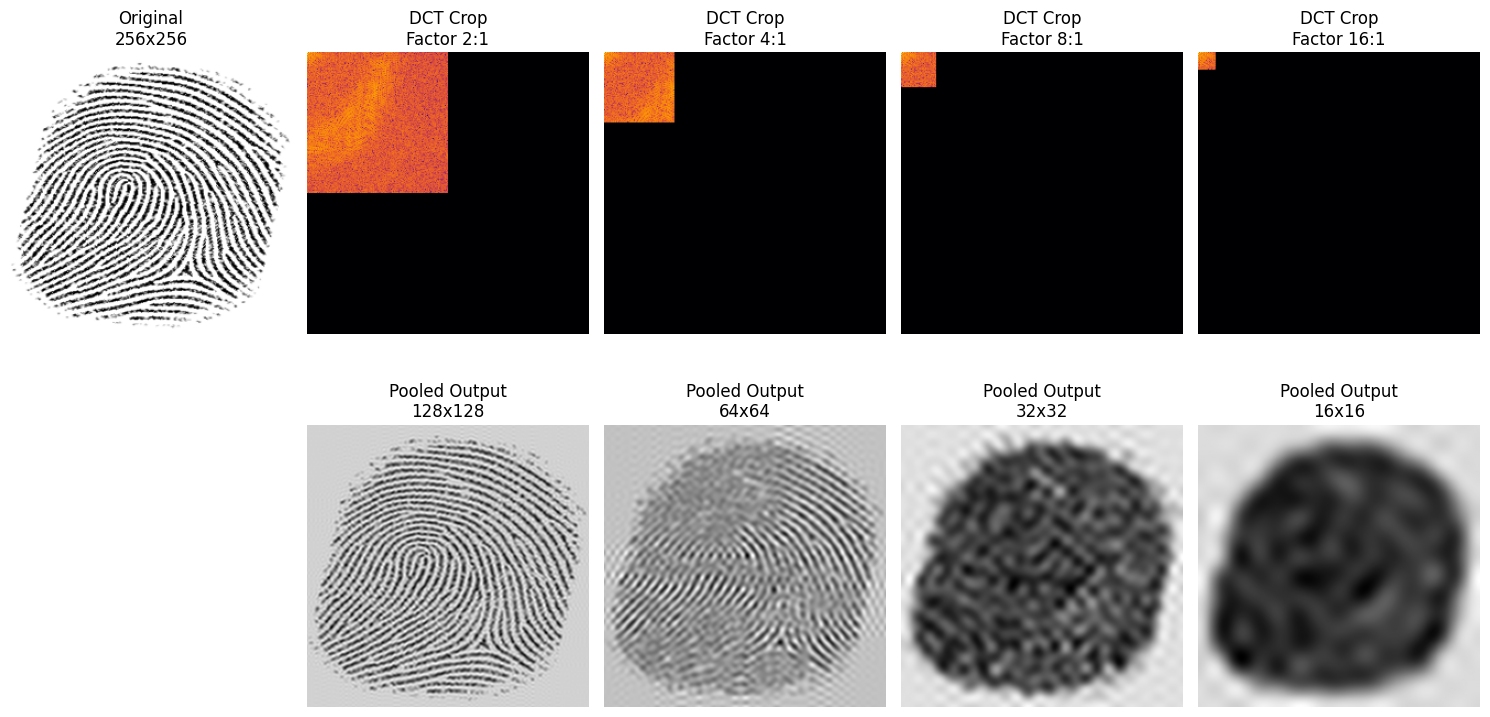

In [ ]:
# image_path = "thumb_fingerprint.png"
image_path = "anguli_fingerprint.png"
process_and_visualize_dct_spectral_pooling(image_path, factors=[2, 4, 8, 16])

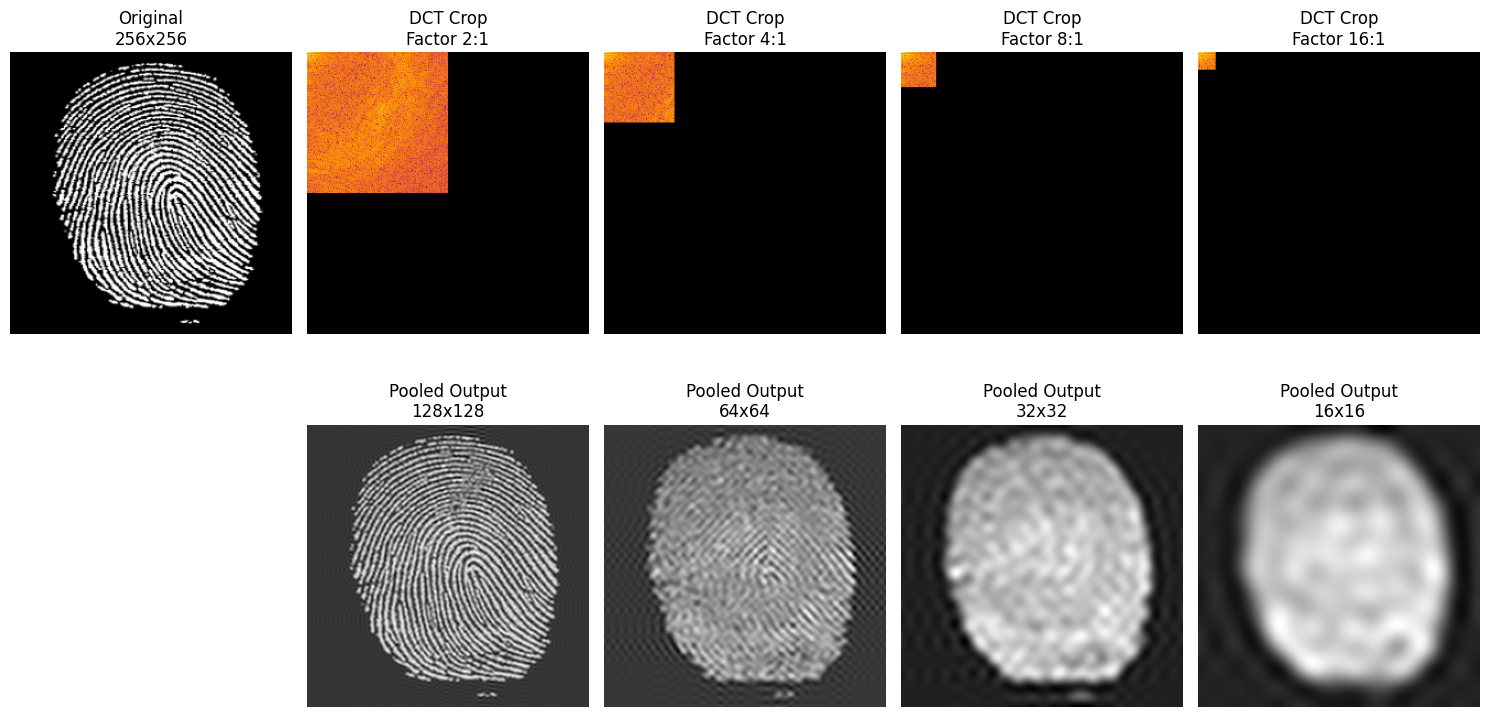

In [14]:
image_path = "inverted_fingerprint.png"
process_and_visualize_dct_spectral_pooling(image_path, factors=[2, 4, 8, 16])